In [43]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import ugradio
import glob
from scipy.interpolate import griddata

%matplotlib inline
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 17})

## Constants

In [21]:
T_NOISE = 90 #K
NUM = 8192 
LO = 1270 #Mhz
RF = 1420.4058 #Mhz
c = 3e5 #km/s

## Creating Functions of Use

In [22]:
def calc_gain(main_data, on_data, off_data):
    
    """
    A simple function to compute the gain for a given coordinate.
    """    
    
#     T_NOISE = 90 # Kelvin
    G = (T_NOISE/(np.sum(on_data-off_data))) * np.sum(off_data) #calc Gain
    
    return G


def calc_velocities(main_file=None):
    
    """
    A simple function to calculate the velocities
    """
    
#     FREQ_RES = 8192 
#     LO = 1270 #Mhz
#     RF = 1420.4058 #Mhz
#     c = 3e5 #km/s
    freqs_range = np.linspace(144, 156, NUM) 
    velocities = (((freqs_range+LO)-RF)/RF)*c #doppler velocities
    
    if main_file is None:
        correction = 0
        
    return (velocities + correction)
    
    
def calc_peak_max(main_file, on_file, off_file):
    
    """
    A function that takes in 3 observational files and performs
    the calibration to convert to temperature and then returns
    the maximum temperature [K] of that coordinate as well as the 
    corresponding velocity [km/s].
    """
    
    main_data = np.mean(np.load(main_file), axis=1)[10:-10]
    on_data = np.mean(np.load(on_file), axis=1)[10:-10]
    off_data = np.mean(np.load(off_file), axis=1)[10:-10]
    
#     T_NOISE = 90 # Kelvin
    
    G = calc_gain(main_data, on_data, off_data)
    max_value = np.max((main_data/off_data))
    max_index = np.argmax((main_data/off_data))
    T = G*(max_value-1)
    velocities = calc_velocities()
    vel = velocities[max_index]
    
    
    fitting_indices = np.where((velocities > -100) & (velocities < 100)) # we zoom in to ignore the ripples
    G = calc_gain(main_data, on_data, off_data)
    
    median = np.median(main_data[fitting_indices]/off_data[fitting_indices]) 
    
    y_data_fit = (main_data/off_data)*G - G*median
    y_data_fit = y_data_fit[fitting_indices]
    x_data_fit = velocities
    x_data_fit = x_data_fit[fitting_indices]
    
    return T, vel

def calc_peak_gaussian(main_file, on_file, off_file):
    
    """
    A function to compute the Temperature [K] and Velocity [km/s] 
    at the peak using a gaussian fit.
    """
    
    main_data = np.mean(np.load(main_file), axis=1)[10:-10]
    on_data = np.mean(np.load(on_file), axis=1)[10:-10]
    off_data = np.mean(np.load(off_file), axis=1)[10:-10]
    
    velocities = calc_velocities()
    
    fitting_indices = np.where((velocities > -100) & (velocities < 100)) # we zoom in to ignore the ripples
    G = calc_gain(main_data, on_data, off_data)
    
    median = np.median(main_data[fitting_indices]/off_data[fitting_indices]) 
    
    y_data_fit = (main_data/off_data)*G - G*median
    y_data_fit = y_data_fit[fitting_indices]
    x_data_fit = velocities
    x_data_fit = x_data_fit[fitting_indices]
    

    fit_params = ugradio.gauss.gaussfit(x_data_fit, 
                                        y_data_fit, 
                                        amp=np.max(y_data_fit),
                                        avg=x_data_fit[np.argmax(y_data_fit)],
                                        sig=10) #get Gaussian fit
    
    
    T, vel = fit_params['amp'][0], fit_params['avg'][0]
                 
    return T, vel

#### Testing that functions work on arb. coordinate set

In [23]:
print(calc_peak_max("data/celestial_data/main_105.000_19.000_.npy",
              "data/celestial_data/on_105.000_19.000_.npy", 
              "data/celestial_data/off_105.000_19.000_.npy"))
    
print(calc_peak_gaussian("data/celestial_data/main_105.000_19.000_.npy",
              "data/celestial_data/on_105.000_19.000_.npy", 
              "data/celestial_data/off_105.000_19.000_.npy"))

(55.44125400186816, 12.534024638678977)
(51.86638822107575, 14.750586730025077)


##

In [24]:
l_min, l_max = 105, 160
b_min, b_max = 15, 50

db = 2
dl = lambda b: 2/np.cos(b * (np.pi/180))

Δb = b_max - b_min
Δl = l_max - l_min

bs = np.array([b_min + i*db for i in range(50) if (b_min + i*db) < b_max])

ls = []
for b in bs:
    ls.append(np.array([l_min + i*dl(b) for i in range(50) if (l_min + i*dl(b)) < l_max]))

coords = []
for i in range(len(bs)):
    for j in range(len(ls[i])):
        coords.append([ls[i][j], bs[i]])

coords = np.array(coords)

coord_names = []
for coord in coords:
    coord_name = f"{coord[0]:0.3f}_{coord[1]:0.3f}"
    coord_names.append(coord_name)

In [34]:
Temps, vels, indices = [], [], []
for i, coord_name in enumerate(coord_names):
    
    on_file = glob.glob('data/celestial_data/on_' + coord_name + '*')
    off_file = glob.glob('data/celestial_data/off_' + coord_name + '*')
    main_file = glob.glob('data/celestial_data/main_' + coord_name + '*')
    
    if on_file and off_file and main_file:
        
        on_file = on_file[0]
        off_file = off_file[0] 
        main_file = main_file[0]
        
        T, V = calc_peak_gaussian(main_file, on_file, off_file)
        
        Temps.append(T)
        vels.append(V)
        indices.append(i)
        
        
valid_coords = coords[indices]

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [60]:
# coord_names
# main = np.load('data/NCP_data_information/main_info.npy')
# main_ls, main_bs = main[0], main[1]#f"{main[0]:0.3f}", f"{main[1]:0.3f}"

In [65]:
# np.sort(main_bs), np.sort(main_ls)

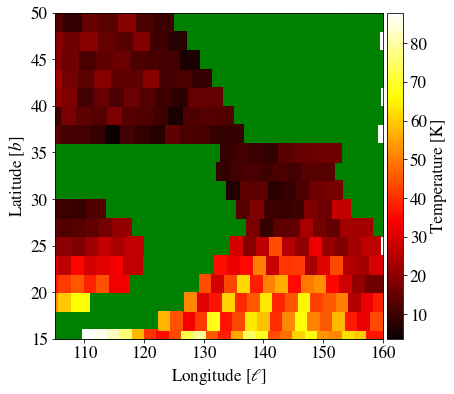

In [42]:
plt.figure(figsize=(7,6))
plt.scatter(coords[:,0], coords[:,1], s=300, marker="s", color="green")
plt.scatter(valid_coords[:,0], valid_coords[:,1], s=350, marker="s", c=Temps, cmap="hot")
plt.xlabel("Longitude [$\\ell$]")
plt.ylabel("Latitude [$b$]")
plt.colorbar(label="Temperature [K]", pad=0.01)
plt.xlim(105, 160)
plt.ylim(15,50)
plt.show()

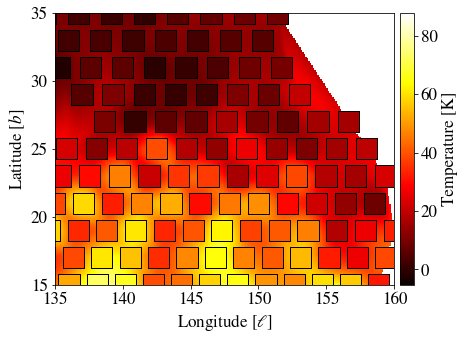

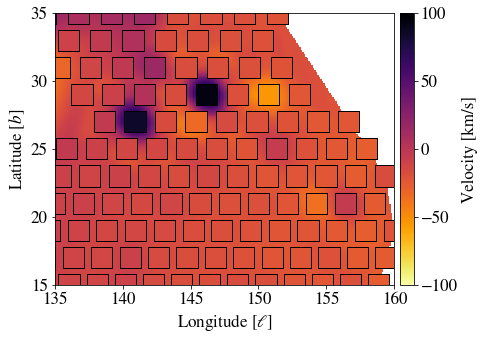

In [51]:
grid_x, grid_y = np.meshgrid(np.linspace(105,160,500),
                             np.linspace(15, 50, 500))

xmin,xmax = 135,160
ymin,ymax = 15,35

grid = griddata(valid_coords, Temps, (grid_x, grid_y), method='cubic')

fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(grid, origin="lower",extent=[105,160,15, 50], cmap="hot", aspect="equal")
ax.scatter(valid_coords
           [:,0],valid_coords[:,1], edgecolor='black',marker="s",s = 450,c=Temps, cmap="hot")
plt.colorbar(im, label="Temperature [K]", pad=0.01)
ax.set_xlabel("Longitude [$\\ell$]")
ax.set_ylabel("Latitude [$b$]")
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
plt.show()

grid_x, grid_y = np.meshgrid(np.linspace(105,160,500),
                             np.linspace(15, 50, 500))

grid = griddata(valid_coords, vels, (grid_x, grid_y), method='cubic')

fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(grid, origin="lower",extent=[105,160,15, 50], 
               cmap="inferno_r", aspect="equal", vmin=-100, vmax=100)
ax.scatter(valid_coords[:,0],valid_coords[:,1], 
           edgecolor='black',marker="s",s = 450,c=vels,
           cmap="inferno_r", vmin=-100, vmax=100)
plt.colorbar(im, label="Velocity [km/s]", pad=0.01)
ax.set_xlabel("Longitude [$\\ell$]")
ax.set_ylabel("Latitude [$b$]")
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
plt.show()